## Bring in libraries and dataframes and set indexes

In [1]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ETFunctions
%matplotlib inline
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import statsmodels.api as sm
import matplotlib.dates as mdates
import GraphHelpers as GH

In [2]:
WaterDelta = pd.read_pickle('.\DataFrames\ProfileWaterDelta.pkl')

In [3]:
GPs = GH.SetGraphicsPatterns(WaterDelta.columns,
                    ['-','--'],
                    [0.15,0.45],
                    ['o','^'],
                    ['orange','green','purple'])

Start = WaterDelta.index.min()
End = WaterDelta.index.max()

Irrigation
['2D', '7D', '14D', '21D', 'MD', 'LD']
Species
['Peas']
Treatments
MultiIndex([( '2D', 'Peas'),
            ( '7D', 'Peas'),
            ('14D', 'Peas'),
            ('21D', 'Peas'),
            ( 'MD', 'Peas'),
            ( 'LD', 'Peas')],
           )
Styles
[('-', 'orange', 0.15, 'o'), ('-', 'green', 0.15, 'o'), ('-', 'purple', 0.15, 'o'), ('--', 'orange', 0.45, '^'), ('--', 'green', 0.45, '^'), ('--', 'purple', 0.45, '^')]
StyleFrame
         Lin     Col   Alp Mar     MFC
2D  Peas   -  orange  0.15   o  orange
7D  Peas   -   green  0.15   o   white
14D Peas   -  purple  0.15   o   white
21D Peas  --  orange  0.45   ^   white
MD  Peas  --   green  0.45   ^   white
LD  Peas  --  purple  0.45   ^   white


C:\Anaconda\lib\site-packages\pandas\core\indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


(-1.0, 5.0)

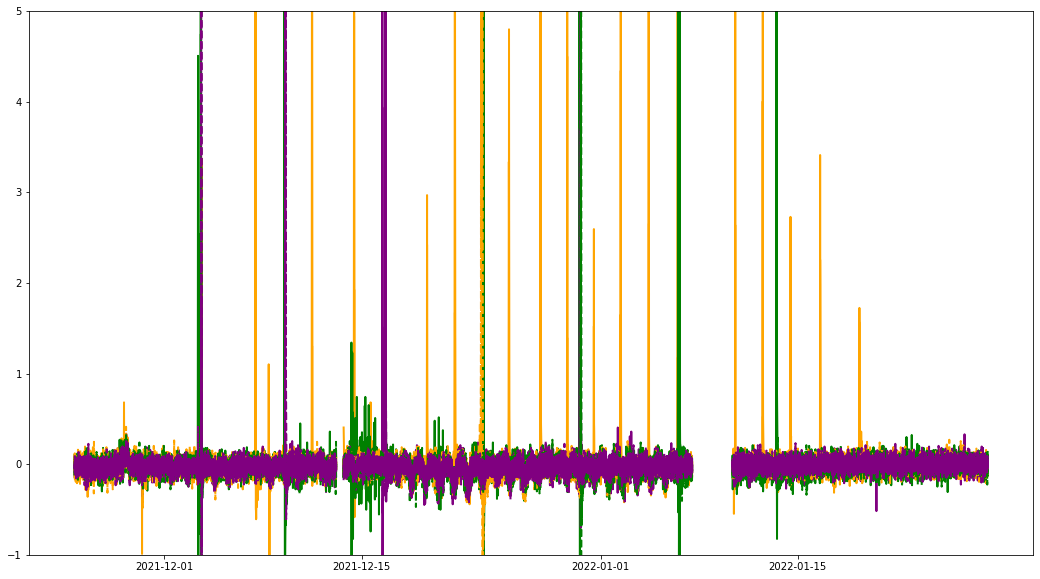

In [4]:
Graph = plt.figure(figsize=(18,10))
ax = Graph.add_subplot(1,1,1)
GH.AddIndexedPlot(WaterDelta,ax,GPs,2)
plt.ylim(-1,5)

## investigate how much upward flux we are getting at night

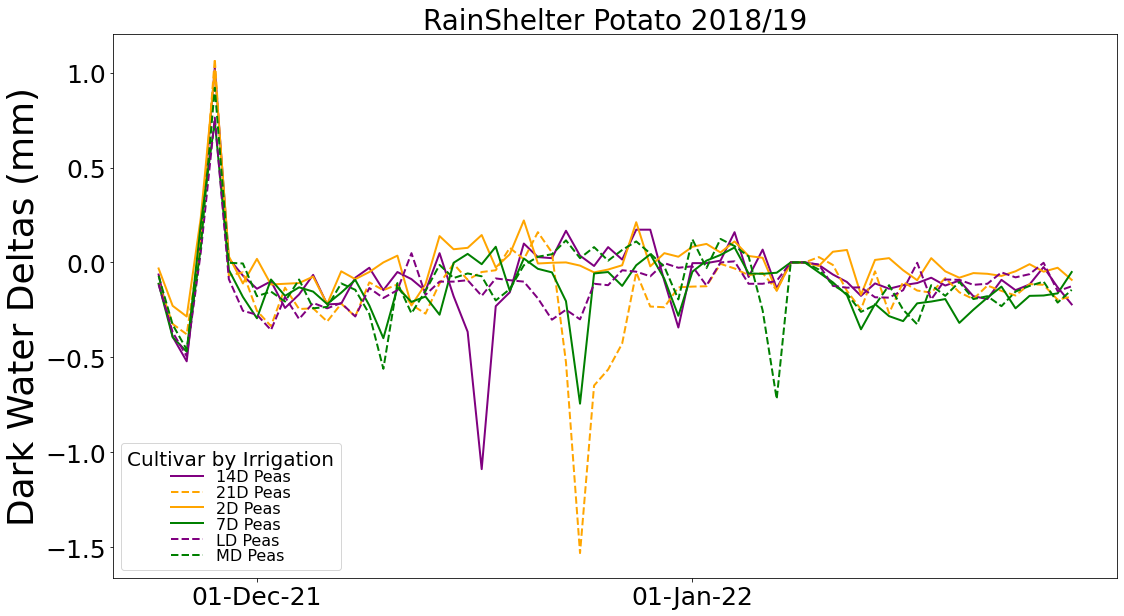

In [5]:
DarkWaterDeltas = WaterDelta.iloc[WaterDelta.index.indexer_between_time(datetime.time(23),datetime.time(4))]
DarkWaterDeltas = DarkWaterDeltas.resample('24H', offset=5).sum()#Offset of 5 means sampling from 6am to 6am
MeanDarkWaterDeltas = DarkWaterDeltas.groupby(level=['Irrigation','Species'],axis=1).mean()
Graph = plt.figure(figsize=(18,10))
ax = Graph.add_subplot(1,1,1)
GH.AddIndexedPlot(MeanDarkWaterDeltas,ax,GPs,2)
plt.ylabel('Dark Water Deltas (mm)', fontsize=36);
plt.tick_params(labelsize=25)
plt.title('RainShelter Potato 2018/19', fontsize=28);
plt.legend(fontsize=24, loc=3)
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%y'))
ledg = plt.legend(loc=3,numpoints=1,fontsize = 16,labelspacing = 0.05, 
                          title='Cultivar by Irrigation')
ledg.get_title().set_fontsize(20)

## No Clear evidence of upward flux for this experiment

## Work out Irrigation timings and amounts.

C:\Anaconda\lib\site-packages\pandas\core\indexing.py:873: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


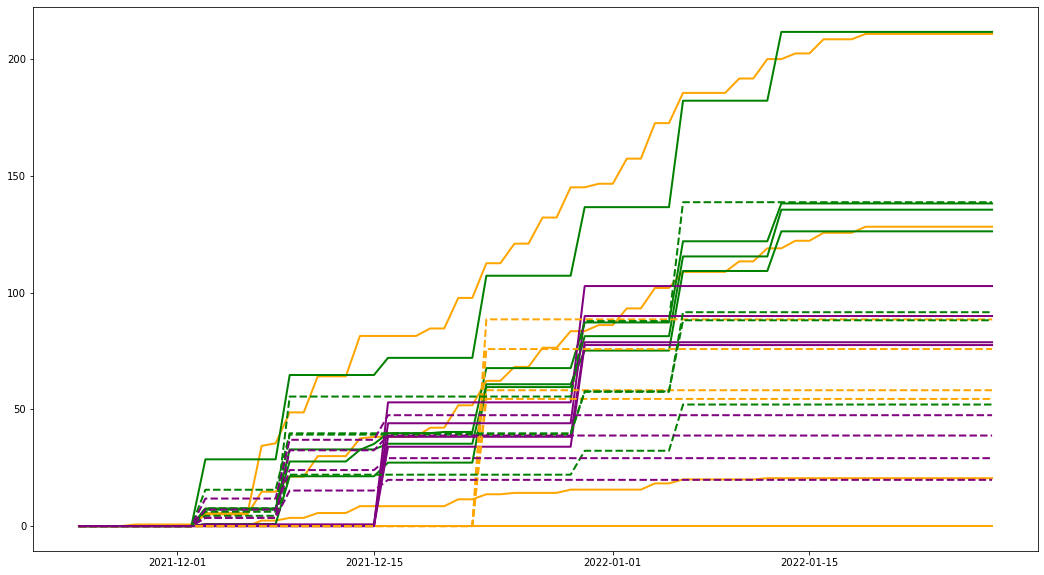

In [6]:
Irrigation = WaterDelta.where(WaterDelta > 0.5)
Irrigation = Irrigation.resample('D').sum()
Irrigation.fillna(0, inplace = True)
AccumIrrig = Irrigation.cumsum()
Graph = plt.figure(figsize=(18,10))
ax = Graph.add_subplot(1,1,1)
GH.AddIndexedPlot(AccumIrrig,ax,GPs,2)

In [7]:
DSIyesterday = 0

DaysSinceIrrigation = pd.DataFrame(index = Irrigation.index, columns = Irrigation.columns)
for col in range(DaysSinceIrrigation.columns.size):
    for x in range(Irrigation.index.size):
        if x == 0:
            DaysSinceIrrigation.iloc[x,col] = float(0)
        else: 
            if Irrigation.iloc[x,col] == 0:
                DaysSinceIrrigation.iloc[x,col] = float(DaysSinceIrrigation.iloc[x-1,col]+1)
            else:
                DaysSinceIrrigation.iloc[x,col] = float(0)

<AxesSubplot:>

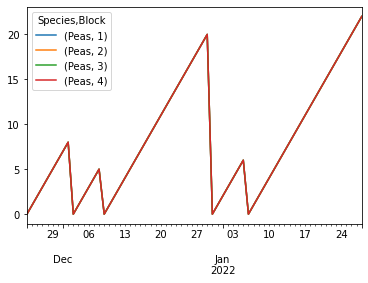

In [8]:
DaysSinceIrrigation.loc[:,'MD'].plot()

In [9]:
IrrDatesD2

NameError: name 'IrrDatesD2' is not defined

In [10]:
IrrDates = DaysSinceIrrigation.loc[:,('2D','Peas','3')] == 0.0
IrrDates2D = IrrDates.loc[IrrDates].index.tolist()
IrrDates = DaysSinceIrrigation.loc[:,('7D','Peas','3')] == 0.0
IrrDates7D = IrrDates.loc[IrrDates].index.tolist()
IrrDates = DaysSinceIrrigation.loc[:,('14D','Peas','3')] == 0.0
IrrDates14D = IrrDates.loc[IrrDates].index.tolist()
IrrDates = DaysSinceIrrigation.loc[:,('21D','Peas','3')] == 0.0
IrrDates21D = IrrDates.loc[IrrDates].index.tolist()
IrrDates = DaysSinceIrrigation.loc[:,('MD','Peas','3')] == 0.0
IrrDatesMD = IrrDates.loc[IrrDates].index.tolist()
IrrDates = DaysSinceIrrigation.loc[:,('LD','Peas','3')] == 0.0
IrrDatesLD = IrrDates.loc[IrrDates].index.tolist()


In [11]:
list(set(IrrDates2D+IrrDates7D+IrrDates14D+IrrDates21D+IrrDatesMD+IrrDatesLD))

[Timestamp('2021-12-03 00:00:00'),
 Timestamp('2021-12-31 00:00:00'),
 Timestamp('2022-01-02 00:00:00'),
 Timestamp('2021-12-07 00:00:00'),
 Timestamp('2021-12-16 00:00:00'),
 Timestamp('2021-12-21 00:00:00'),
 Timestamp('2021-11-24 00:00:00'),
 Timestamp('2022-01-12 00:00:00'),
 Timestamp('2021-12-14 00:00:00'),
 Timestamp('2021-12-23 00:00:00'),
 Timestamp('2022-01-14 00:00:00'),
 Timestamp('2021-12-09 00:00:00'),
 Timestamp('2022-01-10 00:00:00'),
 Timestamp('2021-12-11 00:00:00'),
 Timestamp('2021-12-15 00:00:00'),
 Timestamp('2022-01-16 00:00:00'),
 Timestamp('2022-01-04 00:00:00'),
 Timestamp('2021-12-19 00:00:00'),
 Timestamp('2021-12-25 00:00:00'),
 Timestamp('2021-12-27 00:00:00'),
 Timestamp('2022-01-13 00:00:00'),
 Timestamp('2022-01-06 00:00:00'),
 Timestamp('2022-01-19 00:00:00'),
 Timestamp('2021-12-30 00:00:00'),
 Timestamp('2021-12-29 00:00:00')]

# Calculate hourly water use values

<AxesSubplot:>

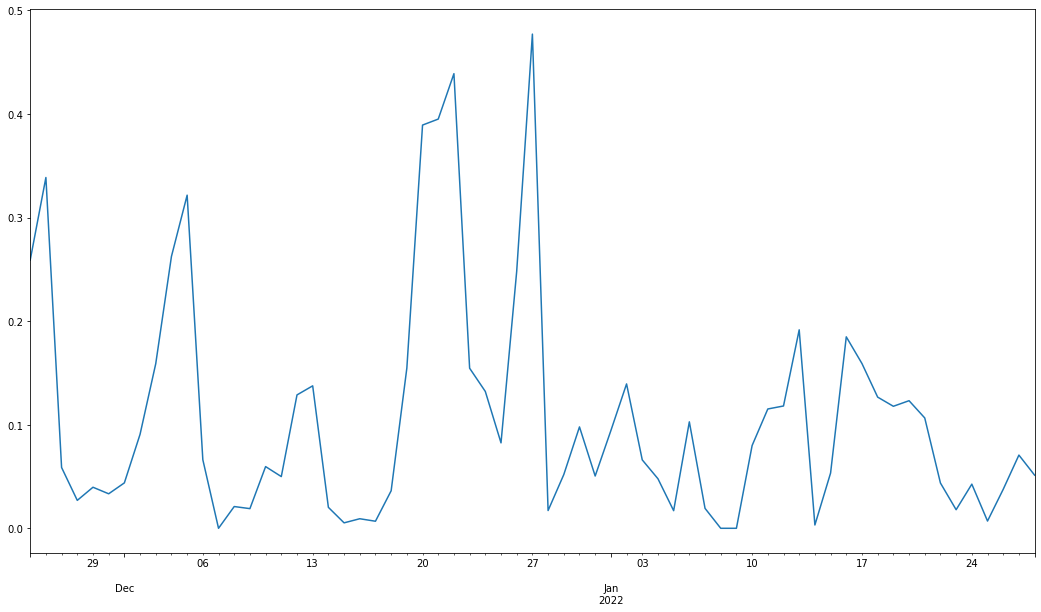

In [12]:
#Bring in night time PET data
NightTimePETAtmospheric = pd.read_pickle('.\DataFrames/NightTimePET.pkl')
NightTimePETAtmospheric.index = NightTimePETAtmospheric.index.normalize()
NightTimePETAtmospheric = NightTimePETAtmospheric.loc['2014-11-08':] #Drop of the first day because it only has a part nights numbers and no day associated wit it
NightTimePETAtmospheric.plot(figsize=(18,10))

## Calculate profile water content deltas for each 1 hour measurement period

(array([18962., 18976., 18993., 19007.]),
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

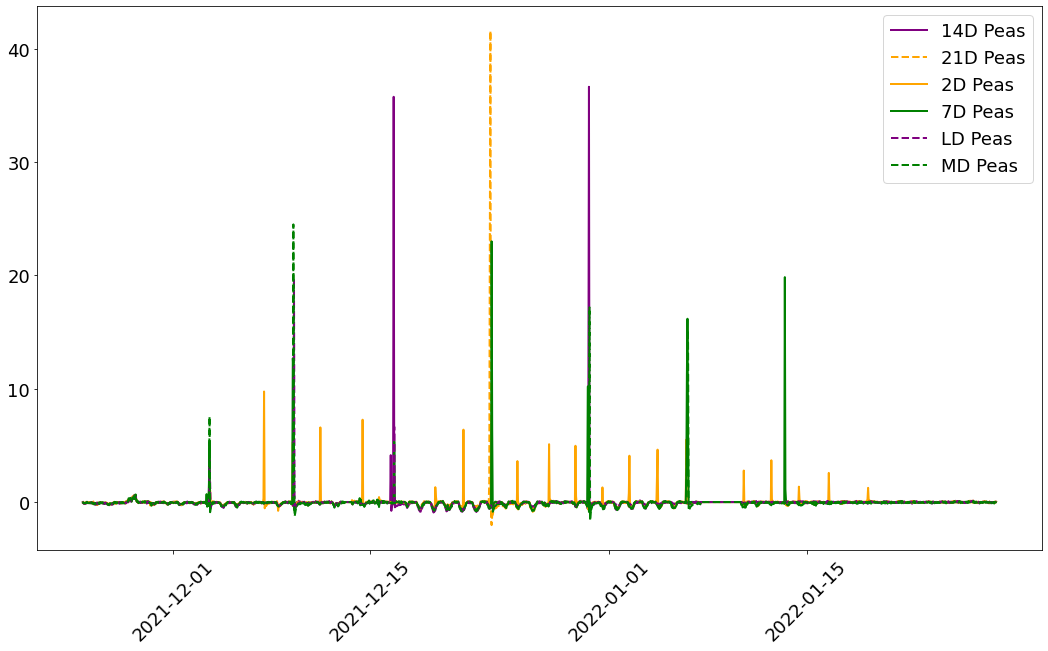

In [13]:
WaterDeltaHourly = WaterDelta.resample('h').sum()
MeanWaterDeltaHourly = WaterDeltaHourly.groupby(level=['Irrigation', 'Species'],axis=1).mean()
SEMWaterDeltaHourly = WaterDeltaHourly.groupby(level=['Irrigation', 'Species'],axis=1).std()/np.sqrt(4)
Graph = plt.figure(figsize=(18,10))
ax = Graph.add_subplot(1,1,1)
GH.AddIndexedPlot(MeanWaterDeltaHourly.loc[:,:],ax,GPs,2)
plt.legend(fontsize=18)
plt.tick_params(labelsize=18)
plt.xticks(rotation=45)


In [15]:
UpwardFlux = DarkWaterDeltas.copy()
UpwardFlux.index = UpwardFlux.index.normalize()
for plot in  UpwardFlux:
    AdjustedFlux = UpwardFlux.loc[:,plot].values
    AdjustedFlux = np.add(AdjustedFlux,NightTimePETAtmospheric.reindex(UpwardFlux.index).values) # Add in the amount of evaporation that would have been replaced
    #AdjustedFlux = np.subtract(AdjustedFlux,NightTimeSoilHeatFlux_mm.loc[UpwardFlux.index,plot].fillna(0))
    UpwardFlux.loc[:,plot] = AdjustedFlux
UpwardFlux = UpwardFlux.multiply(4)  # Multiply by 4 assuming upflux during the day were the same as at night
UpwardFlux.fillna(0, inplace = True)
MeanUpwardFlux = UpwardFlux.groupby(level=['Irrigation','Species'],axis=1).mean()

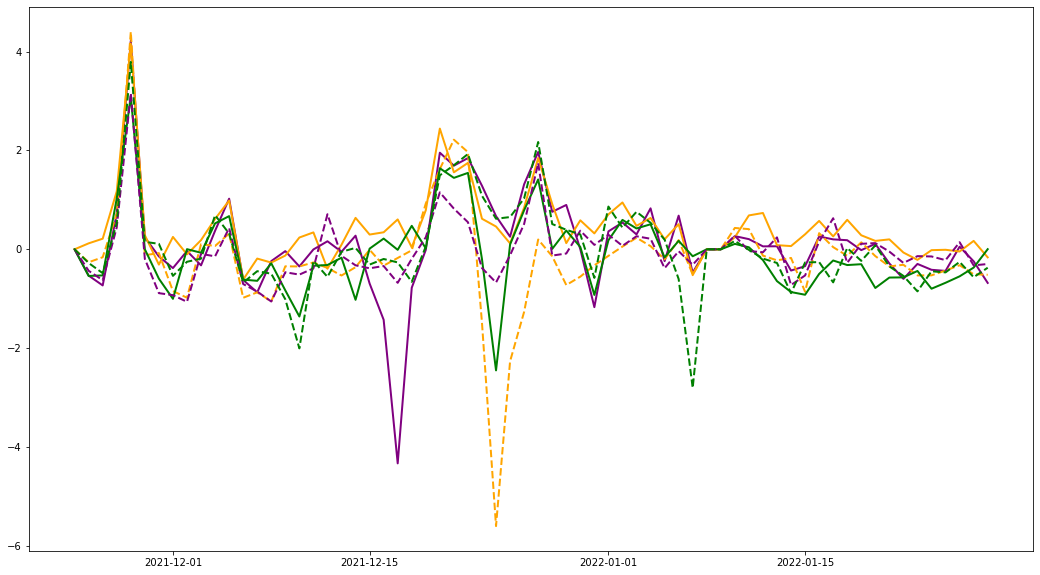

In [16]:
Graph = plt.figure(figsize=(18,10))
ax = Graph.add_subplot(1,1,1)
GH.AddIndexedPlot(MeanUpwardFlux,ax,GPs,2)

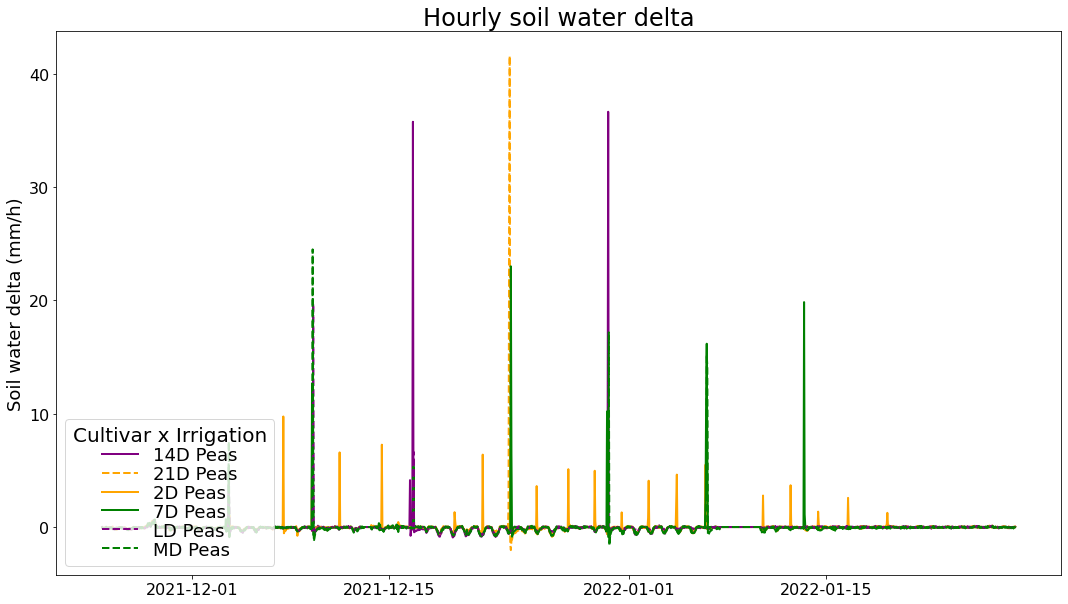

In [17]:
WaterDeltaHourly = WaterDelta.resample('h').sum()
MeanWaterDeltaHourly = WaterDeltaHourly.groupby(level=['Irrigation','Species'],axis=1).mean()
SEMWaterDeltaHourly = WaterDeltaHourly.groupby(level=['Irrigation','Species'],axis=1).std()/np.sqrt(4)
Graph = plt.figure(figsize=(18,10))
ax = Graph.add_subplot(1,1,1)
GH.AddIndexedPlot(MeanWaterDeltaHourly.loc[:],ax,GPs,2)
GH.AddLegend(3,18,"Cultivar x Irrigation")
GH.SetAxProps(title='Hourly soil water delta',titsize=24,
              ylab='Soil water delta (mm/h)',labsize = 18,
              ticsize = 16)

(array([18962., 18976., 18993., 19007.]),
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

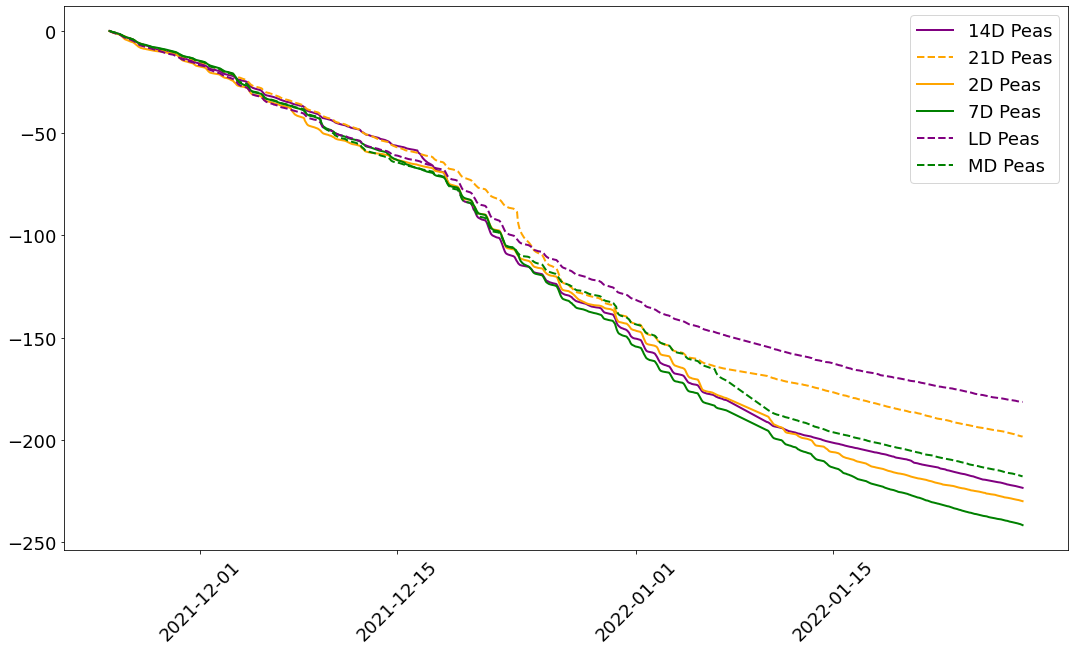

In [25]:
WaterUseHourly = WaterDeltaHourly
WaterUseHourly = WaterUseHourly.where(WaterUseHourly<0)
WaterUseHourly.fillna(method='ffill', inplace = True)
MeanWaterUseHourly = WaterUseHourly.groupby(level=['Irrigation', 'Species'],axis=1).mean()
Graph = plt.figure(figsize=(18,10))
ax = Graph.add_subplot(1,1,1)
GH.AddIndexedPlot(MeanWaterUseHourly.cumsum(),ax,GPs,2)
plt.legend(fontsize=18)
plt.tick_params(labelsize=18)
plt.xticks(rotation=45)

In [92]:
WaterUseHourly.to_pickle('.\DataFrames\HourlyWUmm.pkl')

## Calculate Daily Water Use

In [101]:
#Set up daily water use sums
WaterUseDaily = WaterUseHourly.resample('D').sum()
WaterUseDaily.index.name = 'Date'

#wipe the data on the days when irrigation occured 
WaterUseDaily.loc[IrrDates2D,('2D','Peas')] = np.nan
WaterUseDaily.loc[IrrDates7D,('7D','Peas')] = np.nan
WaterUseDaily.loc[IrrDates14D,('14D','Peas')] = np.nan
WaterUseDaily.loc[IrrDates21D,('21D','Peas')] = np.nan
WaterUseDaily.loc[IrrDatesMD,('MD','Peas')] = np.nan
WaterUseDaily.loc[IrrDatesLD,('LD','Peas')] = np.nan

C:\Anaconda\lib\site-packages\IPython\core\async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)


(array([18953., 18962., 18969., 18976., 18983., 18993., 19000., 19007.,
        19014.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

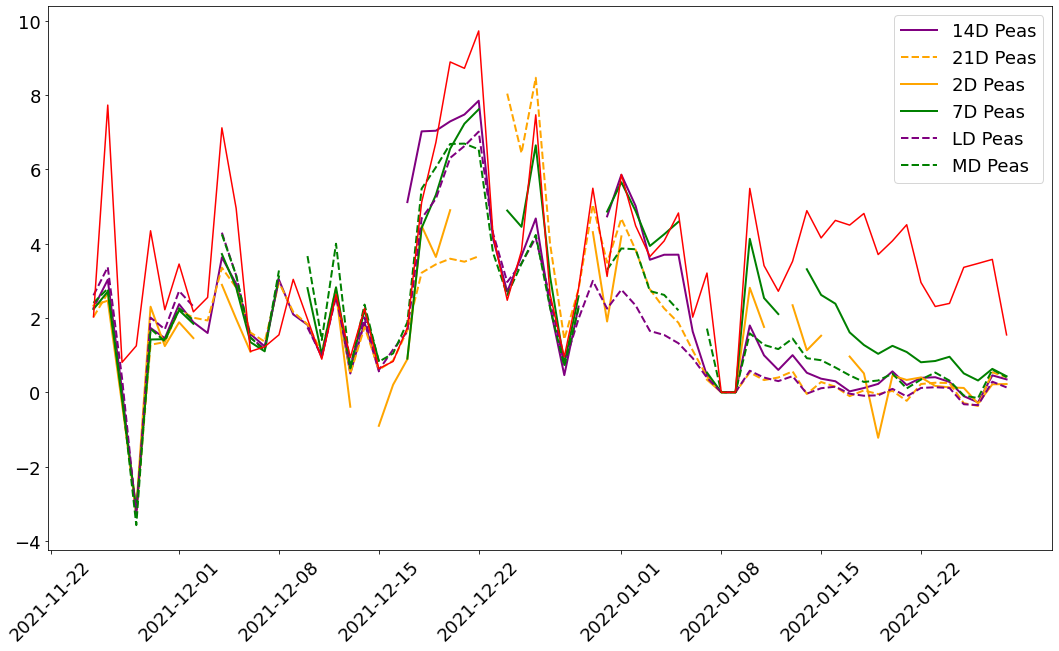

In [102]:
#calculate treatment means
WaterUseDailyMeans = WaterUseDaily.groupby(level=['Irrigation', 'Species'],axis=1).mean()
#Make water use positive
WaterUseDailyMeans = WaterUseDailyMeans.multiply(-1)

Graph = plt.figure(figsize=(18,10))
ax = Graph.add_subplot(1,1,1)
GH.AddIndexedPlot(WaterUseDailyMeans,ax,GPs,2)
DayTimePET = pd.read_pickle('.\DataFrames\DayTimePET.pkl')
DayTimePET.index = DayTimePET.index.normalize()
plt.plot(DayTimePET,'-r')
plt.legend(fontsize=18)
plt.tick_params(labelsize=18)
plt.xticks(rotation=45)



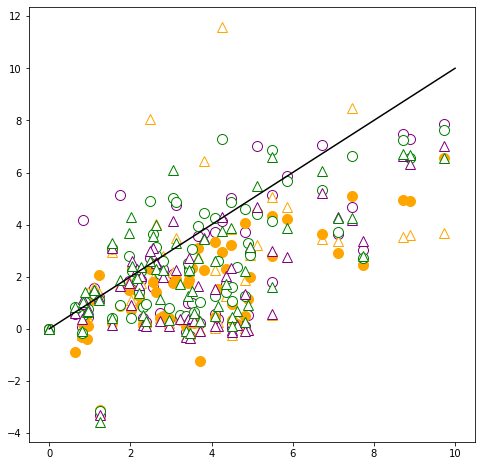

In [100]:
Graph = plt.figure(figsize=(8,8))
ax = Graph.add_subplot(1,1,1)
GH.AddIndexedXY(DayTimePET,WaterUseDailyMeans.reindex(DayTimePET.index.normalize()),ax,GPs,10)
plt.plot([0,10],[0,10],'-k')